# ランダム変数と全要素生産性

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import japanize_matplotlib
import py4macro

## はじめに

```{margin}
<div name="html-admonition">
Do you want to read in a differnt language? Start
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/><input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="translation" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/>
in English or the language of your choice.
</div>
```

GDPなどのマクロ変数は変動し相関性やpersistenceが大きな特徴であるが，経済モデルでどのように捉えれば良いのだろうか。IS-MP-PCモデルのインパルス反応分析でもマクロ変数の変動のような動きはあるが，それがどの程度データと合致しているのか不明である。またIS-MP-PCモデル自体が問題を抱えており，フォーワード・ルッキングな（前向きな最適化行動に基づく）モデルが必要である。このような背景のもと本章の目的は，`Python`でどのようにランダム変数を扱うことができるかを説明することである。

ではなぜマクロ経済学でランダム変数が必要なのだろうか。マクロ変数の変動を説明する上で重要なツールとなっているためである。この点を確認するために，`py4macro`に含まれるデータセット`jpn-q`を使いGDPの変動をプロットする。

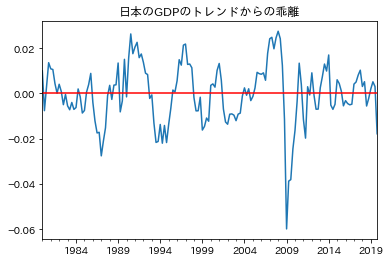

In [2]:
# データの読み込み
df = py4macro.data('jpn-q')

# トレンドからの乖離のデータの作成
df['gdp_cycle'] = np.log( df['gdp']/py4macro.trend(df['gdp']))

# プロット
ax_ = df['gdp_cycle'].plot(title='日本のGDPのトレンドからの乖離')
ax_.axhline(0, c='red')
pass

このようなGDPの変動を説明する方法として２つある。
1. 決定的（deterministic）な過程で生成された時系列
1. ランダム（stochastic）な過程で生成された時系列

１の考えによると，差分方程式$x_{t+1}=f(x_t)$のように今期のGDP（$x_t$）が与えられると来期のGDP（$x_{t+1}$）は自ずと決定さる。従って，来期のGDPの予測は簡単なものとなる。もしそうであれば政策運営は非常に簡単になるだろうが，現実はそうではない。１では現実を捉えることができない。一方，２の考えはランダム変数の実現値の連続としてGDPが観測され，今期のGDPが与えられても来期のGDPにはランダムな要素があるため，予測が難しいという特徴がある。この特徴こそが，マクロ変数の性質を捉えるには必要であり，上のプロットに現れていると考えられる。主流のマクロ経済学では，消費者や企業はフォーワード・ルッキングであり，且つ経済全体でランダムな要素が重要な役割を果たしているという理解に基づき，景気循環の「真のメカニズム」を解明することが目的となっている。

以下では，まずランダム変数生成過程を考え，短期分析における全要素生産性の役割について説明する。またSolowモデルを使い簡単な景気循環モデルを展開する。

## ランダム変数生成コード

ランダム変数の生成について説明する。ここでは`NumPy`の`random`モジュールを使いランダム変数を生成するが，`random`モジュールの中でまず最初に使う必要があるのが`default_rng()`関数である。以下では続くコードを分かりやすくするために`default_rng()`を変数`rng`に割り当てる。

In [3]:
rng = np.random.default_rng()

`rng`はrandom number generatorの略であり，様々なランダム変数のための下準備となる。言い換えると，`rng`はランダム変数を生成するための「種」であり，この「種」に分布関数を指定することによりランダム変数が生成される。以下では正規分布と一様分布の使い方を例に説明する。

```{tip}
ランダム変数の生成にはパッケージ`SciPy`の`stats`モジュールを使うこともできる。興味がある人は[このリンク](https://py4etrics.github.io/5_SciPy_stats.html)を参照しよう。
```

### 正規分布

正規分布に従うランダム変数の生成方法につて説明する。

**コード**

`rng.normal(loc=0, scale=1, size=1)`

* `loc`：平均（デフォルトは`0`）
* `scale`：標準偏差（デフォルトは`1`）
* `size`：ランダム変数の数（デフォルトは`1`）

ここで、`.normal()`は`rng`のメソッドである。例として、平均`5`，標準偏差`2`の標準正規分布から`10`のランダム変数を生成しよう。

In [4]:
rng.normal(5, 2, 10)

array([7.81205024, 4.810642  , 9.22839939, 5.81030844, 4.67900598,
       4.22035719, 2.96448185, 6.48915546, 8.95527164, 5.22273525])

上のコードを実行する度に値が変化することが確認できるはずだ。

標準正規分布から`5`のランダム変数を生成する場合は`loc`と`scale`を省略する。ただし２つ以上のランダム変数を生成する場合はキーワード引数`size=`が必ず必要となる。

In [5]:
rng.normal(size=5)

array([-0.62537254,  1.63974256, -1.9049365 , -0.59521886,  0.71478081])

標準正規分布に従う100,000個のランダムを生成しヒストグラムをカーネル密度制定をプロットしてみよう。

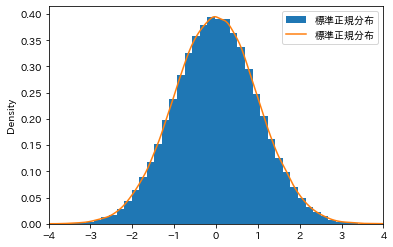

In [6]:
# ランダム変数のDatFrame
df_norm = pd.DataFrame({'標準正規分布':rng.normal(size=100_000)})

# ヒストグラム
ax_ = df_norm.plot(kind='hist', bins=50, density=True)

# カーネル密度関数
df_norm.plot(kind='density',ax=ax_)

# 横軸の表示幅の設定
ax_.set_xlim(-4,4)
pass

### 一様分布

一様分布に従うランダム変数の生成方法につて考える。

**コード**

`rng.uniform(low=0, high=1, size=1)`

* `low`：最小値（デフォルト`0`）
* `high`：最大値（デフォルト`1`）
* `size`：ランダム変数の数（デフォルト`1`）

`.uniform()`も`rng`のメソッドである。最小値`5`，最大値`30`の一様分布から`10`のランダム変数を生成してみよう。

In [7]:
rng.uniform(5, 30, 10)

array([18.31623459, 16.6326388 , 29.7831932 , 15.87388938, 14.4523144 ,
       25.57484038,  6.12570062, 20.98061306, 24.52398436, 24.26254247])

最小値`0`，最大値`1`の一様分布から`5`のランダム変数を生成する。

In [8]:
rng.uniform(size=5)

array([0.79351014, 0.63836275, 0.01371342, 0.27149385, 0.99912775])

標準正規分布に従う100,000個のランダムを生成しヒストグラムをカーネル密度制定をプロットしてみよう。

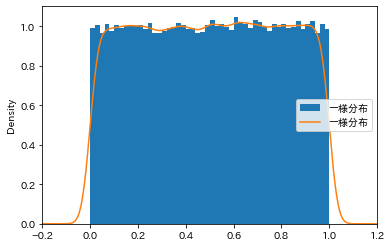

In [9]:
# ランダム変数のDatFrame
df_uni = pd.DataFrame({'一様分布':rng.uniform(size=100_000)})

# ヒストグラム
ax_ = df_uni.plot(kind='hist', bins=50, density=True)

# カーネル密度関数
df_uni.plot(kind='density',ax=ax_)

# 横軸の表示幅の設定
ax_.set_xlim(-0.2,1.2)
pass

## ホワイト・ノイズ

### 説明

時系列のランダム変数$\varepsilon_t$，$t=0,1,2,3,\cdots$を考えよう。例えば，レストランの経営者の収入。ビジネスにはリスク（競争相手の出現やコロナ感染症問題）があるため変動すると考えるのが自然である。$\varepsilon_t$は$t$毎にある分布から抽出されると考えることができる。次の３つの性質を満たしたランダム変数をホワイト・ノイズ（White Noise）と呼ぶ。
1. 平均は`0`：$\quad\text{E}\left[\varepsilon_t\right]=0$
1. 分散は一定：$\text{ E}\left[\varepsilon_t^2\right]=\sigma^2$（$\sigma$に$t$の添字はない）
1. 自己共分散は`0`：$\text{ E}\left[\varepsilon_t \varepsilon_{t-s}\right]=0$（全ての$s\ne 0$に対して）。類似する概念に自己相関係数があり，値が$[-1,1]$になるように標準化されている。。

    $$
    \text{自己相関係数}=\frac{\text{ E}\left[\varepsilon_t \varepsilon_{t-s}\right]}
                           {\sqrt{\text{ E}\left[\varepsilon_t^2\right]\text{ E}\left[\varepsilon_{t-s}^2\right]}}
    $$

＜コメント＞
* 平均0と分散が$\sigma^2$のホワイト・ノイズを次のように表記する。

    $$
    \varepsilon_t\sim\textit{WN}(0,\sigma^2)
    $$
    
* 毎期毎期平均`0`の正規分布から$\varepsilon_t$が抽出されるのであればホワイト・ノイズとなる（正規分布ではない分布でもホワイト・ノイズになり得る）。
* ホワイト・ノイズは独立同分布（Independe and Identically Distributed）の１つである。

### 図示

標準正規分布からのランダム変数を`n`個抽出しプロットしてみよう。

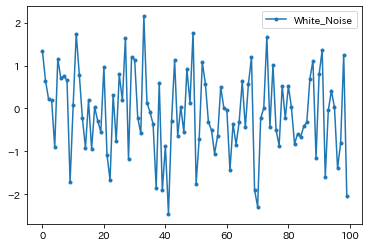

In [10]:
n = 100

vals = rng.normal(size=n)

df_wn = pd.DataFrame({'White_Noise':vals})

df_wn.plot(marker='.')
pass

２つの特徴がある。
* 平均`0`：`0`を中心に周辺を動いている。
* 分散一定：`0`から外れても`0`に戻っている。

平均と分散を計算してみよう。

In [11]:
vals.mean(), vals.var()

(-0.09150618893950734, 0.9785567790936522)

サンプル統計量であるため誤差が発生していることがわかる。

２つの特徴をを確認するために`Pandas`の`plot()`を使ってヒストグラムを描いてみる。

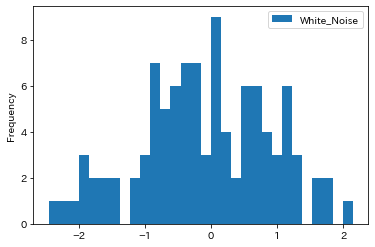

In [12]:
df_wn.plot(kind='hist', bins=30)
pass

概ね`0`を中心に左右対象に動いている。即ち，平均`0`を反映している。また，`0`から離れている観測値が少ないことが分かる。これは`0`方向に戻ることを示している。これは分散が一定であるためである。この性質は`n`を`500`や`1000`などの大きな数字に設定するより一層分かりやすいだろう。

### 自己共分散（自己相関）

次に１期違いの自己共分散$\text{E}[\varepsilon_t \varepsilon_{t-1}]$を考えよう。

In [13]:
current = vals[:-1]
one_period_ahead = vals[1:]

この２つの変数を使って散布図を描いてみる。`Pandas`の`plot()`で横軸・縦軸を指定し，引数`kind`で散布図を指定するだけである。

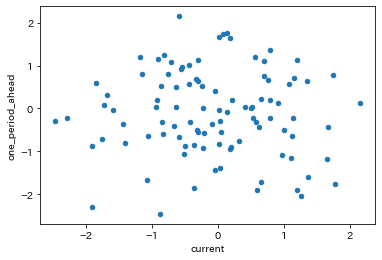

In [14]:
# DataFrameの作成
df_wn2 = pd.DataFrame({'current':current,'one_period_ahead':one_period_ahead})

# 散布図のプロット
df_wn2.plot(x='current', y='one_period_ahead', kind='scatter')
pass

自己共分散がゼロであれば，ランダムに散らばっているはずであり，何らかのパターンも確認できないはずである。

ここで異なるプロットの方法を紹介する。`Pandas`のサブパッケージ`plotting`にある`lag_plot()`関数を使うと共分散の強さを示す図を簡単に作成することが可能となる。
* 必須の引数：１つの列
* オプションの引数：`lag`は時間ラグ（デフォルトは`1`）

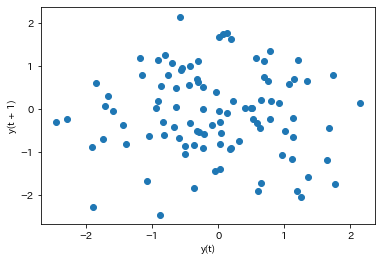

In [15]:
pd.plotting.lag_plot(df_wn)
pass

* 横軸：`t`期の値
* 縦軸：`t+1`期の値

２つの図は同じであることが確認できる。

分散・自己共分散を計算してみよう。

In [16]:
np.cov(current, one_period_ahead)

array([[ 0.95914612, -0.04329217],
       [-0.04329217,  0.97727423]])

右上と左下の値が**自己共分散**であり、非常に小さな値である。自己共分散は`0`という仮定を反映している。（左上は`current`の分散であり、右下は`one_period_ahead`の分散である。）

次にメソッド`autocorr()`を使い**自己相関係数**を計算しよう。

In [17]:
df_wn['White_Noise'].autocorr()

-0.04471557141125595

自己共分散`0`の仮定の反映である。この結果からわかることは，ホワイト・ノイズだけではマクロ変数のpersistenceを説明できないということである。

## 自己回帰モデル：AR(1)

### 説明

次に確率過程として自己回帰モデルを考えよう。英語で**A**ugo**r**egressive Modelと呼ばれ，AR(1)と表記されるモデルは次式で表される。（AR(1)の`(1)`は右辺と左辺の変数は１期しか違わないことを表している。）

$$
y_t=\rho y_{t-1}+\varepsilon_t
$$ (eq:13-ar1)

ここで
* $y_t$：$t$期の$y$の値
* $-1<\rho<1$
* $\varepsilon_t\sim WN(0,\sigma^2)$（ホワイト・ノイズ）

$\varepsilon_t$を所与とすると$y_t$の差分方程式となっている。$-1<\rho<1$となっているため，安定的な過程であることがわかる。即ち，$\varepsilon_t=0$であれば、$y_t=$は定常状態である$0$に近づいて行くことになる。しかしホワイト・ノイズである$\varepsilon_t$により、毎期確率的なショックが発生し$y_t$を定常状態から乖離させることになる。また式[](eq:13-ar1)からわかるように，今期の値$y_t$は前期の値$y_{t-1}$に依存しており，その依存度はパラメータ$\rho$によって決定される。この$\rho$こそが$y_t$のpersistenceの強さを決定することになり，自己回帰モデル[](eq:13-ar1)の自己相関係数は$\rho$と等しくなる。

### ３つの例：Persistenceの違い

直感的にマクロ変数の特徴であるpersistenceとは，前期の値が今期の値にどれだけ影響を持っているかを示す。以下では、同じホワイト・ノイズ$\varepsilon_t$を使い$\rho$の値を変えてpersistenceの違いを考えてみる。そのための関数を作成しよう。

In [18]:
def ar1_model(rho, T=100):
    """引数：
            rho: AR(1)のpersistenceを捉えるパラメータ
            T:   シミュレーションの回数（デフォルト：0）
       戻り値：
            matplotlibの図を示す
            自己相関係数の値を表示する"""
    
    y0 = 0                          # 1
    y_list = [y0]                   # 2
    y = y0                          # 3

    for t in range(1,T):            # 4
        e = rng.normal()            # 5
        y = rho*y + e               # 6
        y_list.append(y)            # 7

    df_ar1 = pd.Series(y_list)      # 8

    ac = df_ar1.autocorr()          # 9
    
    ax_ = df_ar1.plot(marker='.')   # 10
    ax_.set_title(fr'$\rho$={rho}       自己相関係数：{ac:.3f}',size=20) # 11
    ax_.axhline(0, c='red')         # 12

```{admonition} コードの説明
:class: dropdown

1. `y`の初期値を設定。
2. `y`の値を格納するリスト。初期値を入れてある。
3. 左辺の`y`は`for`ループで使うアップデート用の`y`であり，初期値を割り当てている。
4. `T`期間の`for`ループの開始。変数`t`は(4)と(5)に入っていないので単にループの回数を数えている。
    * `range(1,T)`の`1`はループの計算が$t=1$期の`y`の計算から始まるため。$t=0$期の`y`は(1)で与えられている。
5. `t`期のホワイト・ノイズの生成。
6. 右辺の`e`は`t`期のホワイトノイズであり，`y`前期の`y`となっている。
7. `y_list`に`y`を追加。
8. `y_list`を使って`Series`を作成し`df_ar1`に割り当てる。
9. `.autocorr()`を使い己相関係数を計算し`ac`に割り当てる。
10. `y`のプロット
    * `marker='.'`はデータのマーカーを点に設定。
    * 図の「軸」を`ax_`に割り当てる。
11. 図のタイトルの設定
    * `fr`の`f`は`f-string`を表し，`{rho}`と`{ac:.3f}`に数値を代入する。`:.3f`は小数点第三位までの表示を設定
    * `fr`の`r`は`$\rho$`をギリシャ文字に変換するためののも。`$\rho$`は[LaTeX](https://ja.wikipedia.org/wiki/LaTeX)のコード。
12. `.axhline()`は横線をひくメソッド。
```

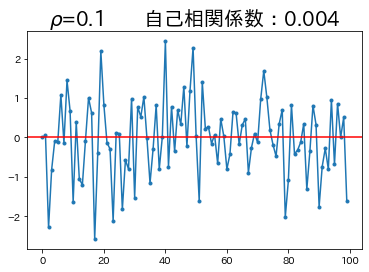

In [19]:
ar1_model(0.1)

この例では$\rho$の値が低いため，$y$は定常状態の0に直ぐに戻ろうとする力が強い。従って、前期の値の今期の値に対する影響力が小さいため、persistenceが低い。

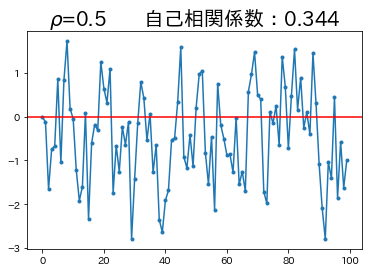

In [20]:
ar1_model(0.5)

$\rho$の値が高くなると、定常状態の$0$に戻ろうとする作用が弱くなり、persistenceが強くなることがわかる。

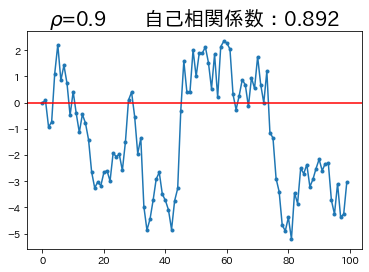

In [21]:
ar1_model(0.9)

$\rho$が非常に高いため、persistenceも非常に強くなっている。即ち、今期の値は前期の値に対する依存度が大きい。

## 全要素生産性

### 説明

マクロ変数の特徴を捉えるにはホワイト・ノイズよりもAR(1)の方がより適しているということが分かった。では，どの様な形でAR(1)をマクロ・モデルに導入すれば良いのだろうか。現在盛んに行われている景気循環研究はDSGEモデル（**D**ynamic **S**tochastic **G**eneral **E**quilibrium Model）と呼ばれるモデルに基づいており、DSGEは名前が示すように次のような特徴がある。
* 時間軸に沿ってマクロ変数の変化を考察する動学的な特徴
* 確率的な要因の重要な役割
* 合理的期待に基づく将来を見据えた消費者と企業の最適行動
* 一般均衡のモデル

そして，DSGE研究の先駆けとなったモデルが実物的景気循環モデル（**R**eal **B**usiness **C**ycles Model; RBCモデル）と呼ばれる理論である。詳細については後の章に譲るが，基本的なアイデアは簡単で全要素生産性（TFP）がAR(1)に従って確率的に変動し，それが消費者と企業の経済行動に影響することにより景気循環が発生するという理論である。ここではデータを使い全要素生産性の性質を考察する。RBCモデルで需要な役割を果たす労働時間についてもデータを使い特徴を探ることにする。

### データ

次の生産関数を仮定する。

$$
Y_t=A_tK_t^aH_t^{1-a}
$$

* $Y_t$：GDP
* $K_t$：資本ストック
* $H_t$：総労働時間（労働者数$\times$労働者平均労働時間）
* $A_t$：TFP

TFPについて解くと次式を得る。

$$
A_t=\dfrac{Y_t}{K_t^aH_t^{1-a}}
$$

景気循環を考えているため、TFPを計算する際には次の点を考慮することが望ましい。
1. 年次データではなく四半期データを使う（年次データでは短期的な変動を捉えることができない）。
1. $H_t$は労働者数ではなく，総労働時間とする（短期的な労働供給の変化を捉えるため）。
1. $K_t$は資本ストックの稼働率を考慮したデータとする（短期的に実際に生産に使われた資本ストックの変化を捉えるため）。

ここでは１と２のみを考慮したデータを使いTFPの変動を考えることにする。これにより資本ストックの稼働率はTFPの一部となってしまうが，RBCモデルの基本的なアイデアは変わらない。

上で読み込んだデータ`df`には次の変数が含まれている（詳細は`GDP：水準・トレンド・変動`を参照）。
* 期間：1980年Q1〜2019年Q4
* `gdp`：国内総生産（支出側）
* `capital`：資本ストック
* `employed`：就業者
* `hours`：労働者1人あたり月平均就業時間（以下では「平均労働時間」と呼ぶ）
* `total_hours`：総労働時間（`hours`$\times$`employed`）

### 労働時間と雇用の特徴

平均労働時間`hours`，就業者数`employed`，総労働時間`total_hours`の特徴を考えてみる。まずサイクルを計算し図示しよう。

In [22]:
df['hours_trend'] = py4macro.trend(df['hours'])
df['hours_cycle'] = np.log( df['hours']/df['hours_trend'] )

df['employed_trend'] = py4macro.trend(df['employed'])
df['employed_cycle'] = np.log( df['employed']/df['employed_trend'] )

df['total_hours_trend'] = py4macro.trend(df['total_hours'])
df['total_hours_cycle'] = np.log( df['total_hours']/df['total_hours_trend'] )

まず平均労働時間を考えよう。

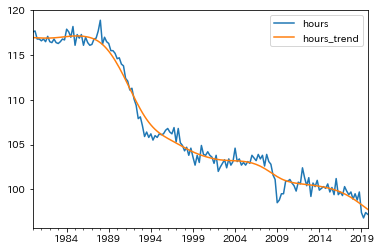

In [23]:
df[['hours','hours_trend']].plot()
pass

平均労働時間は長期的に減少傾向にある。2015年の平均が100に標準化しているので，1980年代には17~8％長かったことを示す。次に，就業者数を図示する。

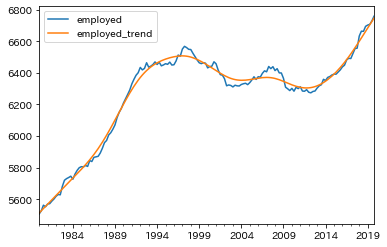

In [24]:
df[['employed','employed_trend']].plot()
pass

一方，雇用者数は増加傾向にある。女性の労働市場参加率の増加や，雇用形態の変化（非正規など）の影響と考えられる。上の２つの変化を反映したのが総労働時間の変化である。

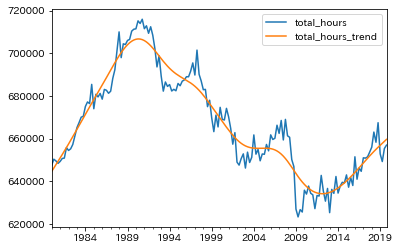

In [25]:
df[['total_hours','total_hours_trend']].plot()
pass

バブル崩壊後は減少傾向にあるが，過去１０年間に持ち直して来ている。これは雇用の拡大の要因が大きい。

雇用と労働時間の変動（トレンドからの乖離率）を比べてみよう。

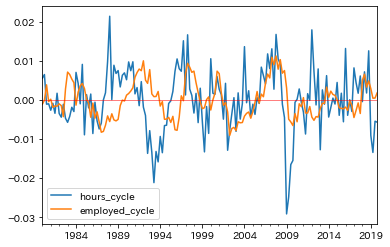

In [26]:
ax_ = df[['hours_cycle','employed_cycle']].plot()
ax_.axhline(0, c='red', lw=0.5)
pass

次の２つの点を指摘できる。
* 労働時間の方が変動が大きい。即ち，総労働時間の調整は就業者数よりも労働時間を通して行われていることが伺える。
* 就業者数の変化は、労働時間の変化を後追いする傾向がある。これは就業者の調整費用がより高いためであろう。

自己相関係数を計算してみる。

In [27]:
cycle_list = ['hours_cycle','employed_cycle','total_hours_cycle']
var_list = ['平均労働時間','就業者数','総労働時間']

print('     自己相関係数\n----------------------')

for c, v in zip(cycle_list,var_list):
    ac = df[c].autocorr()
    print(f'{v:<5}\t{ac:.3f}')  # 1

     自己相関係数
----------------------
平均労働時間	0.481
就業者数 	0.833
総労働時間	0.616


```{admonition} コードの説明
:class: dropdown

1. `:<5`は`f-string`で代入する変数`v`のスペースを`5`に設定し左寄せ`<`にすることを指定している。また`:.3f`は小数点第三位までの表示を指定している。
```

就業者数がより大きな自己相関係数の値となっており，就業者での調整により時間がかかるためである。即ち，今期の就業者数は前期の就業者数に依存するところが大きいという意味である。

次に，GDPのトレンドからの乖離との相関係数を計算してみる。

In [28]:
print('GDPサイクルとの相関係数')
print('-------------------------')

for c, v in zip(cycle_list,var_list):
    corr = df[['gdp_cycle',c]].corr().iloc[0,1]
    print(f'{v:<9}\t{corr:.3f}')

GDPサイクルとの相関係数
-------------------------
平均労働時間   	0.643
就業者数     	0.453
総労働時間    	0.747


やはり非常に強い正の相関があり，平均労働時間の影響が強いようである。

### TFPの特徴

TFPの水準，トレンド，変動（サイクル）を計算するが，資本の所得分配率を次のように仮定する。

In [29]:
a = 0.36

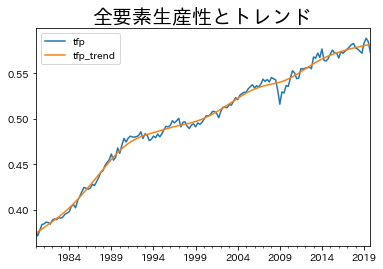

In [30]:
# 全要素生産性の計算
df['tfp'] = df['gdp']/( df['capital']**a * df['total_hours']**(1-a) )

# 全要素生産性のトレンドの計算
df['tfp_trend'] = py4macro.trend(df['tfp'])

# 全要素生産性のトレンドからの乖離の計算
df['tfp_cycle'] = np.log( df['tfp']/df['tfp_trend'] )

# 全要素生産性とトレンドのプロット
ax_ = df[['tfp','tfp_trend']].plot()
ax_.set_title('全要素生産性とトレンド', size=20)
pass

全要素生産性の変動をプロットしよう。

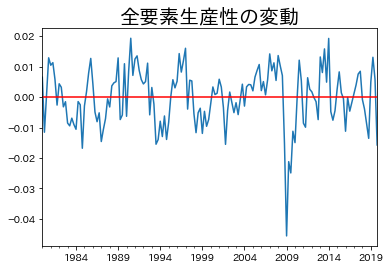

In [31]:
ax_ = df['tfp_cycle'].plot()
ax_.axhline(0, c='red')
ax_.set_title('全要素生産性の変動', size=20)
pass

この図から全要素生産性の変動は大きいことが分かる。変動の最小値と最大値を確認してみよう。

In [32]:
100*df['tfp_cycle'].min(), 100*df['tfp_cycle'].max()

(-4.558373158766421, 1.9303257666063687)

正の乖離は2％近くあり，負の乖離は4％以上となる。リーマンショック時を除くと正も負も絶対値で概ね2％以内に収まっている。

GDPと一緒にプロットしてみよう。

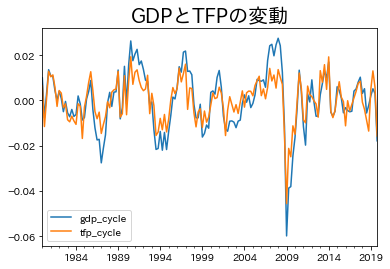

In [33]:
ax_ = df[['gdp_cycle','tfp_cycle']].plot()
ax_.set_title('GDPとTFPの変動',size=20)
pass

同じ方向に動いているのが確認できる。GDPの変動との相関係数を計算してみると，非常に高いことがわかる。

In [34]:
df[['gdp_cycle','tfp_cycle']].corr().iloc[0,1]

0.8837353731027301

以前の計算結果を使うと，この数字はGDPのどの構成要素よりも高いことが確認できる。次に，自己相関係数を計算してみよう。

In [35]:
df['tfp_cycle'].autocorr()

0.5467923296454527

`gdp_cycle`程ではないが、強いpersistenceがあることが確認できる。

In [36]:
df['gdp_cycle'].autocorr()

0.7644516243720126

＜これらの結果の含意＞

全要素生産性の変動は大きくpersistenceも高い。またGDPとの相関性も大きい。これらから全要素生産性が景気循環を引き起こす要因ではないかということが示唆される。全要素生産性は資本や労働時間で説明できないGDPの要素であり，そのような「その他」の部分に景気循環を引き起こすランダムな要素が隠されているかも知れない，という考え方である。

### AR(1)としてのTFP

全要素生産性を景気循環の要因として捉えるために，全要素生産性をAR(1)としてモデル化しみみようというのがこの節の目的である。そのために`statsmodels`を使い回帰分析をしてみよう。まず１期ずらした変数を作成する。

In [37]:
df['tfp_cycle_lag'] = df['tfp_cycle'].shift()

```{admonition} コードの説明
:class: dropdown

`shift()`は`Series`を１期ずらすメソッドである。
```

In [38]:
df[['tfp_cycle','tfp_cycle_lag']].head()

,tfp_cycle,tfp_cycle_lag
,,
1980-03-31,0.006504,NaN
1980-06-30,-0.011544,0.006504
1980-09-30,0.000867,-0.011544
1980-12-31,0.012880,0.000867
1981-03-31,0.010449,0.012880


列`tfp_cycle_lag`は列`tfp_cycle`を１期ずらしていることが確認できる。次に回帰分析をおこなう。

In [39]:
res_tfp = sm.ols('tfp_cycle ~ -1 + tfp_cycle_lag', data=df).fit()
rho = res_tfp.params[0]
rho

0.5508112208781349

```{admonition} コードの説明
:class: dropdown

回帰式の中に`-1`とあるが、定数項を省く場合に指定する。
```

自己相関係数と殆ど変わらない値である。２つの変数の散布図を表示してみよう。

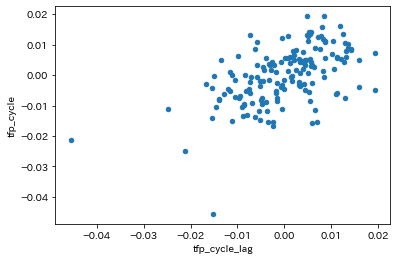

In [40]:
df.plot(x='tfp_cycle_lag',y='tfp_cycle',kind='scatter')
pass

正の相関が図でも確認できる。次に$\epsilon_t$について考える。この変数はホワイト・ノイズであり、TFPショックの「源泉」である。平均0の正規分布としてモデル化するが，その標準偏差の推定値を上の回帰式の標準偏差の分散と考えよう。

In [41]:
sigma = np.std(res_tfp.resid,ddof=1)
sigma

0.007836966505771637

```{admonition} コードの説明
:class: dropdown

* `res_tfp`の属性`.resid`は残差を返している。
* 引数`ddof`は標本の標準偏差の計算に必要な自由度の設定であり，説明変数が１なので`ddof=1`を設定している。
```

初期値は0として`rho`と`sigma`を使ってAR(1)の値を計算してプロットしてみよう。

自己相関係数：0.536


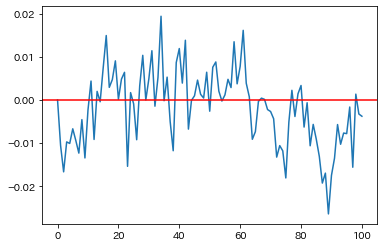

In [42]:
T = 100        # 標本の大きさ
A = 0          # 初期値
A_list = [A]   # 値を格納するリスト

for i in range(T):
    e = np.random.normal(loc=0,scale=sigma)
    A = rho*A+e
    A_list.append(A)

df_A = pd.Series(A_list)            # Seriesの作成
ax_ = df_A.plot()                   # 図示
ax_.axhline(0, c='red')             # 0の平行線

ac_tfp = df_A.autocorr()       # 自己相関係数の計算
print(f'自己相関係数：{ac_tfp:.3f}')

シミュレーションを行う度に図と自己相関係数は異なることになる。

## 確率的ソロー・モデル

### 説明

上で日本のデータを使い全要素生産性の`rho`と`sigma`を計算しシミュレーションを行なったが，そのような全要素生産性の変動が景気循環の主な要因と考えるのがRBCモデルと呼ばれるものである。RBCモデルの詳細については後の章で検討するが，ここではその導入としてソロー・モデルにAR(1)としてのTFPを組み込んでシミュレーションをおこない，計算結果をデータと比べてどの程度整合性があるかを検討する。

モデルの均衡式として以下を使う。
* 生産関数：$Y_t=A_tB_tK_t^aH^{1-a}$
    * $A_tB_t$が全要素生産性
    * $A_t$は変動を捉える項
    
        $$
        \begin{align*}
        \log(A_{t})&=\rho\log(A_{t-1})+\varepsilon_t \\
        \varepsilon_t&\sim \textit{WH}(0,\sigma^2)
        \end{align*}
        $$

    * $B_t$はトレンドを捉える項
    
        $$
        B_t=B_0(1+g)^t
        $$
    
* 資本の蓄積方程式：$K_{t+1}=sY_t+(1-d)K_t$
* 消費：$C_t=(1-s)Y_t$
* 投資（貯蓄）：$I_t=sY_t$

これらの式から次の2式で$K_t$と$A_t$の値が計算できる。

$$
\begin{align*}
K_{t+1}&=sA_tB_tK_t^aH^{1-a}+(1-d)K_t\\
\log(A_{t+1})&=\rho\log(A_{t})+\varepsilon_{t+1}
\end{align*}
$$

変数の初期値を次のように仮定する。
* $A_0=1$
* $K_0=$ 1980年の資本ストックの平均
* $H_0=$ 1980年の総労働時間の平均

パラメータの値を次を仮定する。
* $\rho$と$\sigma$は上で計算した`rho`と`sigma`の値
* $g=$ 1980年から2019年までの平均四半期成長率
* $s=$ 1980年から2019年までのGDPに占める投資の割合の平均
* $d=0.025$：年率約10％を想定
* $a=0.36$：資本の所得割合

シミュレーションの結果を次の変数を含む`DataFrame`にまとめる。
* $Y$，$C$，$I$，$K$，$A$の水準の系列
* $Y$，$C$，$I$，$K$，$A$のトレンドの系列
* $Y$，$C$，$I$，$K$，$A$の変動（サイクル）の系列

### 初期値の計算

まずGDP，資本，総労働時間の1980年と2019年の平均を計算する。

In [43]:
var_list = ['gdp','capital','total_hours'] # 1
year_list = ['1980','2019']                # 2

gdp_dict = {}  # 3
K_dict = {}    # 4
H_dict = {}    # 5

for yr in year_list:        # 6
    mean = df.loc[f'{yr}-03-31':f'{yr}-12-31',var_list].mean() # 7
    gdp_dict[yr] = mean[0]  # 8
    K_dict[yr] = mean[1]    # 9
    H_dict[yr] = mean[2]    # 10

```{admonition} コードの説明
:class: dropdown

1. ３つの変数のリスト
2. 平均を計算する年のリスト
3. それぞれの年のGDPの平均を格納する辞書
4. それぞれの年の資本ストックの平均を格納する辞書
5. それぞれの年の総労働時間の平均を格納する辞書
6. `year_list`に対しての`for`ループ
7. それぞれの年の行，`var_list`にある列を抽出し平均を計算する。
    * `f-string`を使い`{yr}`に年を代入している。
    * `.mean()`は列の平均を計算する。
    * 計算した平均は`Series`として返されるので，それを左辺にある変数`mean`に割り当てる。
8. `mean`の0番目の要素を`gdp_dict`のキー`yr`（年）に対応する値をして設定する。
9. `mean`の1番目の要素を`K_dict`のキー`yr`（年）に対応する値をして設定する。
10. `mean`の2番目の要素を`H_dict`のキー`yr`（年）に対応する値をして設定する。
```

このコードの結果を確認してみよう。例えば，

In [44]:
gdp_dict

{'1980': 260466.05, '2019': 536203.9249999999}

キー・値の２つの対がある。キー`1980`の値には1980年のGDPの平均が設定されており，同様に，キー`2019`の値には2019年のGDPの平均が設定されている。従って，次のコードで`1980`年の値にアクセスできる。
```
gdp_dict['1980']
```
他の辞書も同様である。

````{admonition} なぜforループを使うのか。
:class: tip

上のコードで`for`ループを使っているが，もし使わなければ次のようなコードになる。
```
var_list = ['gdp','capital', 'total_hours']
mean1980 = df.loc['1980-03-31':'1980-12-31',var_list].mean()
mean2019 = df.loc['2019-03-31':'2019-12-31',var_list].mean()

gdp1980 = mean1980[0]
K1980 = mean1980[1]
H1980 = mean1980[2]

gdp2019 = mean2019[0]
K2019 = mean2019[1]
H2019 = mean2019[2]
```
同じようなコードが並んでいる。`py4macro`のデータがアップデートされて`2020`年までのデータが含まれることになったとしよう。`for`ループを使うコードであれば`2019`を`2020`に一ヵ所だけ変更すれば良い（変更する必要もないコードを書くことも可能）。`for`ループを使わないコードで何ヵ所修正する必要があるか数えてみよう。面倒と感じないだろうか。それに修正箇所が増えればbugが紛れ込む可能性が増えていく。
````

次に全要素生産性の平均四半期成長率を計算するために`df`の列名を確認しよう。

In [45]:
df.columns

Index(['gdp', 'consumption', 'investment', 'government', 'exports', 'imports',
       'capital', 'employed', 'unemployed', 'unemployment_rate', 'hours',
       'total_hours', 'inflation', 'gdp_cycle', 'hours_trend', 'hours_cycle',
       'employed_trend', 'employed_cycle', 'total_hours_trend',
       'total_hours_cycle', 'tfp', 'tfp_trend', 'tfp_cycle', 'tfp_cycle_lag'],
      dtype='object')

`gdp`は0番目，`capital`は6番目，`total_hours`は11番目の列にある。この情報をもとに次のように計算しよう。

In [46]:
var_idx = [0,6,11]         # 1
df0 = df.iloc[0,var_idx]   # 2
df1 = df.iloc[-1,var_idx]  # 3

# 4
B0 = df0['gdp']/( df0['capital']**a * df0['total_hours']**(1-a))

# 5
B1 = df1['gdp']/( df1['capital']**a * df1['total_hours']**(1-a))

no_quarters = len(df)      # 6

g = (B1/B0)**(1/no_quarters)-1  # 7
g

0.0026200422015019154

```{admonition} コードの説明
:class: dropdown

1. 3つの変数の列インデックのリスト
2. 最初の行で3つの変数だけを抽出し`df0`に割り当てる。
3. 最後の行で3つの変数だけを抽出し`df1`に割り当てる。
4. 最初の四半期の全要素生産性の計算
5. 最後の四半期の全要素生産性の計算
6. 四半期の数
7. 平均四半期成長率の計算
```

次にGDPに対する投資の割合の平均を計算する。

In [47]:
s = (df['investment']/df['gdp']).mean()
s

0.20356557332919753

約20％が投資に回されている。最後にモジュール`py4macro`に含まれるデータセット`pwt`を使い日本の資本減耗率の平均を計算しよう。

### シミュレーション

#### 関数

シミュレーションのコードを関数としてまとめよう。

In [48]:
def stochastic_solow(T=160,  # 160=40*4 40年間の四半期の数
                     rho=rho,
                     sigma=sigma,
                     g=g,
                     s=s,
                     d=0.025,
                     a=a,
                     H=H_dict['1980'],
                     K0=K_dict['1980'],
                     B0=B0):
    """引数：
            T:     シミュレーションの回数
            rho:   AR(1)のパラメータ
            sigma: ホワイト・ノイズ分散
            g:     TFPの平均四半期成長率
            s:     貯蓄率
            d:     資本減耗率
            a:     生産関数のパラメータ（資本の所得割合）
            H:     総労働時間
       返り値
            次の変数を含むDataFrame
            GDP，消費，投資，資本ストック，全要素生産性の水準，トレンド，変動"""
    
    # ========== A,B,Kの計算 ==========
    # 計算結果を格納するリスト
    A_list = [1]    # 1
    B_list = [B0]   # 2
    K_list = [K0]   # 3

    # 初期値でありアップデート用変数
    A = 1           # 4
    B = B0          # 5
    K = K0          # 6

    # A,B,Kの時系列の計算
    for t in range(1,T):
        K = s * A*B * K**a *H**(1-a) + (1-d)*K  # 7
        
        e = np.random.normal(0,scale=sigma)     # 8
        A = A**rho * np.exp(e)                  # 9
        B = B0*(1+g)**t                         # 10
        
        A_list.append(A)                        # 11
        B_list.append(B)
        K_list.append(K)
    
    # ========== DataFrameの作成 ==========
    df_sim = pd.DataFrame({'K':K_list,          # 12
                           'A':A_list,
                           'B':B_list})

    # ========== Y,C,Iの計算 ==========          # 13
    df_sim['Y'] = df_sim['A']*df_sim['B']*df_sim['K']**a * H**(1-a)
    df_sim['C'] = (1-s)*df_sim['Y']
    df_sim['I'] = s*df_sim['Y']
    
    # ========== トレンドとサイクルの計算 ==========
    for v in ['K','A','Y','C','I']:
        # ---------- レンドの計算 ----------      # 14
        df_sim[f'{v}_trend'] = py4macro.trend(df_sim[v])
        # ---------- サイクルの計算 ----------    # 15
        df_sim[f'{v}の変動'] = np.log( df_sim[v]/df_sim[f'{v}_trend'] )
    
    return df_sim

```{admonition} コードの説明
:class: dropdown

1. `A`の値を格納する空のリスト。初期値が入っている。
2. `B`の値を格納する空のリスト。初期値が入っている。
3. `K`の値を格納する空のリスト。初期値が入っている。
4. `for`ループでアップデートされる`A`の値を一次的に格納する。最初は初期値が入っている。
5. `for`ループでアップデートされる`B`の値を一次的に格納する。最初は初期値が入っている。
6. `for`ループでアップデートされる`K`の値を一次的に格納する。最初は初期値が入っている。
7. 右辺では(4)~(6)の値（`A`，`B`，`K`）を使い来期の`K`を計算し，その値を左辺の`K`に割り当てる。この瞬間に(6)の`K`がアップデートされる。
8. 来期のホワイト・ノイズの値を生成し`e`に割り当てる。
9. 右辺では(4)の値（`A`）を使い来期の`A`の値を計算し，その値を左辺の`A`に割り当てる。この瞬間に(4)の`A`がアップデートされる。
10. 右辺では来期の`B`の値を計算し，その値を左辺の`B`に割り当てる。この瞬間に(5)の`B`がアップデートされる。
11. リスト(1)~(3)に来期値を追加する。
12. リスト(1)~(3)を使いDataFrameの作成
13. `Y`，`C`，`I`を計算し新たな列としてDataFrameに追加
14. トレンドを計算し新たな列としてDataFrameに追加
    * `f-string`を使って新しく作る列名を`K_trend`のように`_trend`を追加する。
15. トレンドからの乖離を計算し新たな列としてDataFrameに追加
    * `f-string`を使って新しく作る列名を`K_cycle`のように`_cycle`を追加する。
```

#### 実行

デフォルトの値でシミュレーションを行い、最初の5行を表示する。

In [49]:
df_sim = stochastic_solow()
df_sim.head()

,K,A,B,Y,C,I,K_trend,Kの変動,A_trend,Aの変動,Y_trend,Yの変動,C_trend,Cの変動,I_trend,Iの変動
0,768601.675000,1.000000,0.376813,259894.572371,206988.984741,52905.587630,768503.565415,0.000128,0.995637,0.004373,260522.036632,-0.002411,207488.718880,-0.002411,53033.317752,-0.002411
1,802292.220755,0.999471,0.377800,264491.101967,210649.819155,53841.282812,802346.163555,-0.000067,0.995486,0.003996,264691.740477,-0.000758,210809.614571,-0.000758,53882.125906,-0.000758
2,836076.198048,0.995362,0.378790,268044.593465,213479.942118,54564.651346,836188.823013,-0.000135,0.995337,0.000025,268861.052157,-0.003041,214130.197929,-0.003041,54730.854228,-0.003041
3,869738.944444,0.987394,0.379782,270410.902927,215364.552438,55046.350489,870031.571394,-0.000336,0.995197,-0.007872,273029.454108,-0.009637,217450.056747,-0.009637,55579.397361,-0.009637
4,903041.821321,0.989534,0.380777,275407.609978,219344.101953,56063.508024,903874.365912,-0.000922,0.995070,-0.005578,277195.918478,-0.006472,220768.372409,-0.006472,56427.546070,-0.006472


$Y$の水準とトレンドの図示。

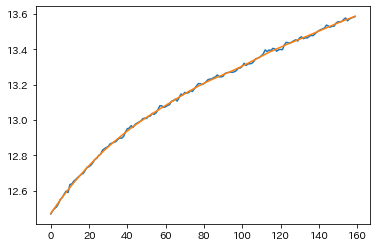

In [50]:
np.log(df_sim['Y']).plot()
np.log(df_sim['Y_trend']).plot()
pass

トレンドの傾きは成長率を表しているが，徐々に減少していることが分かる。最初は成長率に対する資本蓄積の効果が大きいが，定常状態に近づくにつれて資本蓄積の効果が減少しているためである。

$Y$の変動（サイクル）の図示。

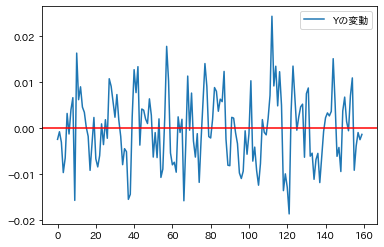

In [51]:
ax_ = df_sim['Yの変動'].plot(legend=True)
ax_.axhline(0, c='red')
pass

絶対値で約2％内に収まった変動となっている。データでは，リーマンショック時はマイナス約4％程乖離したが，それ以外は絶対値で2％以内に収まっており，シミュレーションは概ねデータと同じような特徴を持っていると言える。

#### 結果

それぞれの変数の自己相関係数を計算してみる。

In [52]:
var_list = ['Y','C','I','K','A']

print('\n--- シミュレーション：変動の自己相関係数 ---\n')

for v in var_list:
    ac = df_sim[f'{v}の変動'].autocorr()
    print(f'{v}の変動： {ac:.3f}')


--- シミュレーション：変動の自己相関係数 ---

Yの変動： 0.405
Cの変動： 0.405
Iの変動： 0.405
Kの変動： 0.893
Aの変動： 0.398


まずシミュレーションを行う度にこれらの値は変化することに留意し結果を考えよう。ある程度の自己相関が発生しており，$A$の影響が反映されている。$Y$，$C$，$I$の値は同じなのは，$C$，$I$は$Y$の線形関数であるためであり，これらの３つの変数は$A$の変動と似た動きになっている。また$K$の値が大きいのは、ストック変数であるため変化に時間が掛かるためある。データ`df`に含まれる変数の自己相関係数と比べるために，まず消費，投資，資本の変動を計算する。

In [53]:
data_var_list = ['consumption','investment','capital']

for v in data_var_list:
    df[f'{v}_cycle'] = np.log( df[v]/py4macro.trend(df[v]) )

結果を示すために，`data_var_list`の最初と最後に`gdp`と`tfp`を追加する。

In [54]:
data_var_list = ['gdp']+data_var_list+['tfp']

In [55]:
print('\n--- データ：変動の自己相関係数 ---\n')

for v in data_var_list:
    ac = df[f'{v}_cycle'].autocorr()
    print(f'{v:>11}の変動： {ac:>5.3f}')      # 1


--- データ：変動の自己相関係数 ---

        gdpの変動： 0.764
consumptionの変動： 0.522
 investmentの変動： 0.838
    capitalの変動： 0.892
        tfpの変動： 0.547


```{admonition} コードの説明
:class: dropdown

1. `f-string`を使って変数`v`と`ac`を代入している。
    * `:>11`は`v`を表示する幅を`11`に設定し右寄せ（`>`）にしている。
    * `:>5`は`ac`を表示する幅を`5`に設定して右寄せ（`>`）にしている。
    * `.3f`は`ac`を小数点第三位までを表示するように指定している。
```

実際の資本ストックは非常に大きなpersistenceがあり、シミュレーションの結果はそれを捉えている。しかし他の変数に関してはpersistenceが足りないようである。

しかしシミュレーションの結果はランダム変数の実現値に依存しているので，シミュレーションを行う度に異なる結果が出てくる。また，このシミュレーションでは`T=160`として40年間を考えたが，`T`の値によっても結果は大きく左右される。`T`を大きくするとより安定的な結果になっていくだろう。例えば，`T=10_000`を試してみよう。

次に、$Y$との相関係数を計算する。

In [56]:
print('\n--- シミュレーション：GDPとの相関係数 ---\n')

for v in var_list[1:]:
    cov = df_sim[['Yの変動',v]].corr().iloc[0,1]
    print(f'{v}の変動： {cov:.3f}')


--- シミュレーション：GDPとの相関係数 ---

Cの変動： 0.033
Iの変動： 0.033
Kの変動： 0.003
Aの変動： 0.917


* $C$と$I$の値は1.0となっている理由は$Y$と線形になっているためであり，全く同じように変動するためである。
* $Y$と$A$は非常に強く相関している。生産関数を見ると，両変数も線形の関係があり，$K$の変化によって変化のズレが生じるメカニズムとなっているためである。

相関度をデータと比べてみよう。

In [57]:
print('\n--- データ：GDPとの相関係数 ---\n')

for v in data_var_list[1:]:
    cor = df[['gdp_cycle',f'{v}_cycle']].corr().iloc[0,1]
    print(f'{v:>11}の変動：{cor:>5.3f}')


--- データ：GDPとの相関係数 ---

consumptionの変動：0.706
 investmentの変動：0.816
    capitalの変動：0.179
        tfpの変動：0.884


$C$と$I$に関してはシミュレーションの相関係数は大きすぎる結果となっている。

確率的ソロー・モデルによるシミュレーション結果は，マクロ変数の特徴を捉えている部分もあるが景気循環モデルとして考えるには難しいだろう。消費者の効用最大化問題が欠落しているため，$Y$，$C$，$I$が全く同じように動くのがネックになり，消費や投資の特徴を捉えることができていない。後の章で議論するが，消費者の最適化問題や将来の予測などを導入したRBCモデルは，よりデータに近い結果となる。しかし，いくつか問題が残るのも事実である。
* TFPショックとは何なのか？
    * 生産関数を見る限りTFPは生産性を表している。技術水準，政府の規制，政治システムや経済制度の変化を捉えると考えられ，例えば，ビジネスに対する規制の強化によって負のショックが発生する。しかし，それだけで実際に観測されるGDPの大きな変動（例えば、リーマン・ショックやコロナ・ショック）を説明するのには疑問である。
* ソロー・モデルも含めて価格調整が瞬時に行われるが，次の問題が残る。
    * 古典派の二分法が成立すると仮定するが、短期的には無理がある仮定（例えば、賃金）。
    * 景気循環に対して金融政策は無力なのか？
    
このような問題意識を持って，RBCモデルとニューケインジアン・モデルを議論していくことにする。